In [1]:
import torch
from sam2.build_sam import build_sam2_video_predictor
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt
import numpy as np

checkpoint = "sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
video_predictor = build_sam2_video_predictor(model_cfg, checkpoint)
image_predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

/home/roiro/Code/segment_tools/.venv/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: You are using PyTorch 2.1.0+cu121 without Flash Attention v2 support. Consider upgrading to PyTorch 2.2+ for Flash Attention v2 (which could be faster).
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
/home/roiro/Code/segment_tools/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'sam2.1_hiera_tiny.pt'

In [ ]:
def show_mask(mask, image, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    # 画像にマスクを適用
    masked_image = image.copy()
    masked_image[:,:,:3] = np.where(mask.reshape(h, w, 1), mask_image[:,:,:3], masked_image[:,:,:3])
    return masked_image

def show_points(coords, labels, image, marker_size=200):
    h, w, _ = image.shape
    marker_radius = int(marker_size / 100)
    
    for (x, y), label in zip(coords, labels):
        if label == 1:  # Positive points (green)
            color = (0, 1, 0)
        else:           # Negative points (red)
            color = (1, 0, 0)
        
        rr, cc = np.meshgrid(
            np.clip(np.arange(int(y) - marker_radius, int(y) + marker_radius + 1), 0, h - 1),
            np.clip(np.arange(int(x) - marker_radius, int(x) + marker_radius + 1), 0, w - 1),
            indexing='ij'
        )
        image[rr, cc, :3] = color
    
def show_box(box, image):
    x0, y0 = int(box[0]), int(box[1])
    x1, y1 = int(box[2]), int(box[3])
    h, w, _ = image.shape
    
    image = np.ascontiguousarray(image)
    
    # 緑色の境界線を描画
    image[y0:y1, x0:x0+2, :3] = (0, 1, 0)  # 左端
    image[y0:y1, x1-2:x1, :3] = (0, 1, 0)  # 右端
    image[y0:y0+2, x0:x1, :3] = (0, 1, 0)  # 上端
    image[y1-2:y1, x0:x1, :3] = (0, 1, 0)  # 下端

In [ ]:
import gradio as gr
import numpy as np
import cv2
import os
import shutil
import subprocess
from tqdm import tqdm
from gradio_rangeslider import RangeSlider

# 初期化
points = np.empty((0, 2), dtype=np.float32)
labels = np.empty((0,), dtype=np.int32)
row_frames = []
video_segments = {}
video = ""

# sam2の実行
def process_sam2(video_def, range_slider):
    global video_segments
    global row_frames
    global video
    video = video_def
    
    slider_min, slider_max = range_slider
    
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float16):
        # tempフォルダのパス
        temp_dir = 'temp'
        # tempフォルダが存在する場合、削除する
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)
        # 空のtempフォルダを作成する
        os.makedirs(temp_dir, exist_ok=True)

        # ffmpegコマンドを実行
        # command = f"ffmpeg -i {video} -q:v 2 -start_number 0 {temp_dir}/%05d.jpg"
        command = f"ffmpeg -i {video} -vf 'select=between(n\,{int(slider_min)}\,{int(slider_max)})' -vsync vfr -q:v 2 {temp_dir}/%05d.jpg"
        subprocess.run(command, shell=True)

        state = video_predictor.init_state(temp_dir)
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=state,
            frame_idx=0,
            obj_id=1,
            points=points,
            labels=labels,
        )
        
        for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(state):
            video_segments[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }
    # print(video_segments)

    cap = cv2.VideoCapture(video)
    # slider_minからslider_maxまでのフレームを取得
    cap.set(cv2.CAP_PROP_POS_FRAMES, slider_min)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    if os.path.exists("temp_output"):
        shutil.rmtree("temp_output")
    os.makedirs("temp_output", exist_ok=True)
    
    out = cv2.VideoWriter(f"temp_output/{os.path.basename(video)}", fourcc, fps, (width, height))
    for idx, video_segment in tqdm(video_segments.items()):
        ret, row_frame = cap.read()
        row_frames.append(row_frame)
        output_seg_image = show_mask(video_segment[1], row_frame)
        out.write(output_seg_image)
    out.release()
    row_frames = np.array(row_frames)
    return f"temp_output/{os.path.basename(video)}"




# セグメンテーションを単一画像に対して実行する
def segment_single_img(frame, points, labels):
    image_predictor.set_image(frame)
    masks, scores, logits = image_predictor.predict(
        point_coords=points,
        point_labels=labels,
        multimask_output=False,
    )
    return show_mask(masks, frame)

# ポイントを描画する
def draw_points(frame, points, labels):
    img = frame.copy()
    for (x, y), label in zip(points, labels):
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(img, (int(x), int(y)), 5, color, -1)
    return img

# クリックイベントの処理
def on_click(frame, label_type, evt: gr.SelectData):
    global points, labels
    x, y = evt.index[0], evt.index[1] # クリックした座標を取得
    if label_type == "positive":
        points = np.append(points, [[x, y]], axis=0)
        labels = np.append(labels, [1])
    elif label_type == "negative":
        points = np.append(points, [[x, y]], axis=0)
        labels = np.append(labels, [0])
    return draw_points(frame, points, labels), segment_single_img(frame, points, labels)

# 削除
def delete_last(frame):
    global points, labels
    if len(points) > 0:
        points = points[:-1]
        labels = labels[:-1]
    return draw_points(frame, points, labels), segment_single_img(frame, points, labels)

# リセット
def reset(frame):
    global points, labels
    points = np.empty((0, 2), dtype=np.float32)
    labels = np.empty((0,), dtype=np.int32)
    return draw_points(frame, points, labels), frame

# 動画から最初のフレームを取得
def get_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cap.release()
    if not ret:
        raise ValueError("動画の最初のフレームを取得できませんでした。")
    return frame

# 動画から任意のフレームを取得し、任意のフレームとフレーム数を返す
def get_n_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idx = min(frame_num, frame_count - 1)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cap.release()
    if not ret:
        raise ValueError("動画のフレームを取得できませんでした。")
    return frame, frame_count

def update_range_text(slider_value):
    print(slider_value[0], slider_value[1])
    
# Gradioインターフェースの設定
with gr.Blocks() as demo:
    video = gr.Video(sources="upload")
    with gr.Row():
        with gr.Column():
            label_type = gr.Radio(["positive", "negative"], label="Label Type", value="positive")
            range_slider = RangeSlider(minimum=0, maximum=100, value=(0, 100), visible=False)
        output_img = gr.Image(type="numpy", label="Processed Image")
        
    output_img_seg = gr.Image(type="numpy", label="Processed Image Seg", interactive=False)
    orig_img = gr.Image(type="numpy", visible=False) # 画像の元の状態を保持(ポイント付きの画像は使えないため)
    execute_btn = gr.Button("ビデオセグメンテーションを実行")
    delete_btn = gr.Button("最後のポイントを削除")
    reset_btn = gr.Button("すべてのポイントを削除")
    output_video = gr.Video()
    
    def update_first_frame(video_path):
        frame, frame_count = get_n_frame(video_path, 0)
        return [frame, frame, gr.update(maximum=frame_count, value=(0, frame_count), visible=True)]
    
    def update_nframe(video_path, range_slider):
        frame, frame_count = get_n_frame(video_path, range_slider[0])
        return [frame, frame]
    
    # 動画がアップロードされた場合、最初のフレームを取得
    video.change(update_first_frame, [video], [output_img, orig_img, range_slider])
    # レンジスライダーの値が変更された場合、任意のフレームを取得
    range_slider.change(update_nframe, [video, range_slider], [output_img, orig_img])
    # 画像をクリックした場合、ポイントを追加
    output_img.select(on_click, [orig_img, label_type], [output_img, output_img_seg])
    # ビデオセグメンテーションを実行
    execute_btn.click(process_sam2, [video, range_slider], output_video)
    # ポイントの削除
    delete_btn.click(delete_last, orig_img, [output_img, output_img_seg])
    # リセット
    reset_btn.click(reset, orig_img, [output_img, output_img_seg])
    
demo.launch(debug=True)

which: no node in (/home/roiro/Code/segment_tools/.venv/bin:/nix/store/qdsimqhpg5ln8fy3xnaywrqdqsp7sglh-glib-2.80.2-bin/bin:/nix/store/p5441mp6wwpdh65qamaixvd092cwr45h-bash-interactive-5.2p26/bin:/nix/store/cy6j2yii4y9jlbqr10k190v0b3jdbwl3-patchelf-0.15.0/bin:/nix/store/r73z9i18vbjcph7k2f3isrysxzx6sqjx-gcc-wrapper-13.2.0/bin:/nix/store/llmjvk4i2yncv8xqdvs4382wr3kgdmvp-gcc-13.2.0/bin:/nix/store/z5gvbj7p7dr89k42ncrl2mlv5v3ymjlp-glibc-2.39-52-bin/bin:/nix/store/ysqx2xfzygv2rxl7nxnw48276z5ckppn-coreutils-9.5/bin:/nix/store/bl7gf4crmr480jfm8raswv9xn2v1qwiw-binutils-wrapper-2.41/bin:/nix/store/7v7g86ml0ri171gfcrs1d442px5bi1p3-binutils-2.41/bin:/nix/store/bspjl8ddqiiybcwwvfcimi7n7wvwpv9z-ffmpeg-6.1.1-bin/bin:/nix/store/ysqx2xfzygv2rxl7nxnw48276z5ckppn-coreutils-9.5/bin:/nix/store/36rvynxwln7iz0qq3k1v3r1mna8bma8s-findutils-4.9.0/bin:/nix/store/0fw4a3z849azkhyjxnpxbygj4g5qhd0v-diffutils-3.10/bin:/nix/store/7xwbkzfrs6flyvjyvd23m8r2mlnycinq-gnused-4.9/bin:/nix/store/d9xr7s3z0r8rf0ba22q6ilqv68agym

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/home/roiro/Code/segment_tools/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/roiro/Code/segment_tools/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

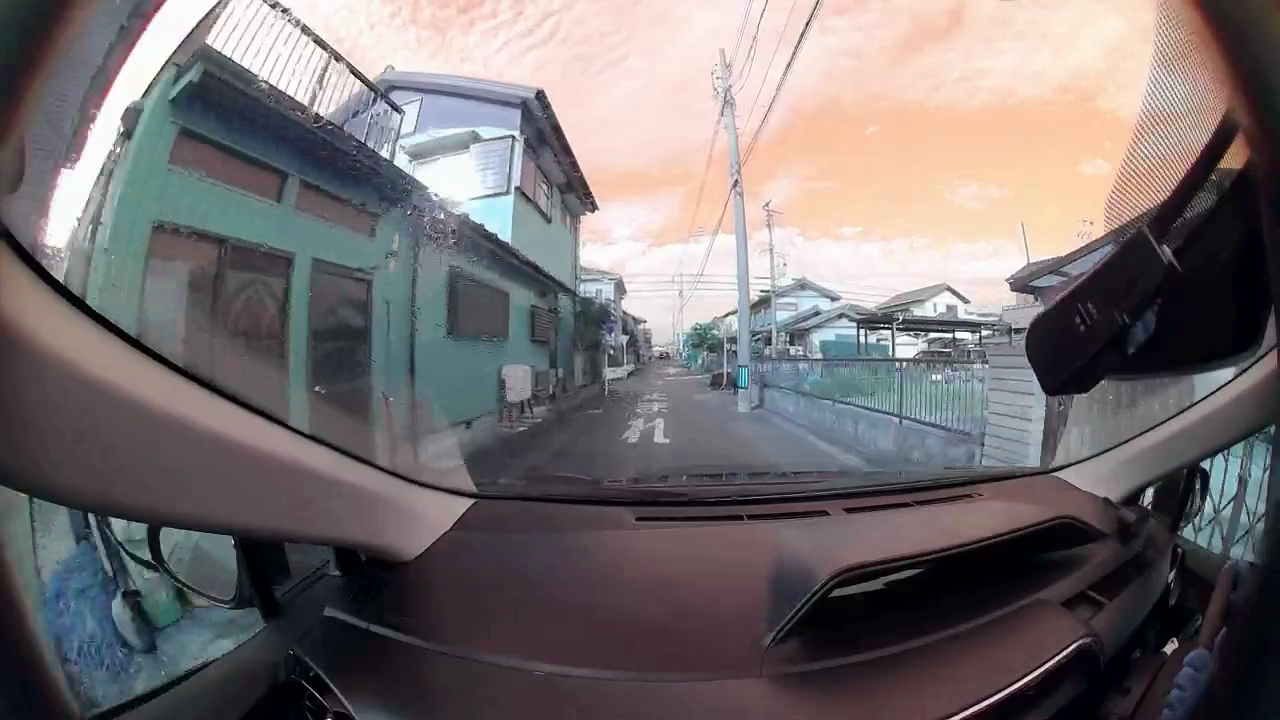

In [ ]:
from PIL import Image
Image.fromarray(row_frames[0])

In [ ]:
# video_segmentsの値をn, h, wに変換
n, h, w, _ = row_frames.shape
video_segments_reshaped = np.zeros((n, h, w))
for idx, video_segment in video_segments.items():
    video_segments_reshaped[idx] = video_segment[1]
print(video_segments_reshaped.shape)

(347, 720, 1280)


In [ ]:
for (idx, video_segment), (frame) in zip(video_segments.items(), row_frames):
    print(f"{idx:05}.zip", video_segment[1].shape)#これがマスクデータですよ　falseを０にしてtrueをいちにしよう npz zipみたいなの
    # print(idx, frame.shape)
    # np.savez_compressed(f"/home/fujitm/unagi/npz/{os.path.basename(video)}-{idx:05}.npz", image=frame, mask=video_segment[1])

00000.zip (1, 720, 1280)
00001.zip (1, 720, 1280)
00002.zip (1, 720, 1280)
00003.zip (1, 720, 1280)
00004.zip (1, 720, 1280)
00005.zip (1, 720, 1280)
00006.zip (1, 720, 1280)
00007.zip (1, 720, 1280)
00008.zip (1, 720, 1280)
00009.zip (1, 720, 1280)
00010.zip (1, 720, 1280)
00011.zip (1, 720, 1280)
00012.zip (1, 720, 1280)
00013.zip (1, 720, 1280)
00014.zip (1, 720, 1280)
00015.zip (1, 720, 1280)
00016.zip (1, 720, 1280)
00017.zip (1, 720, 1280)
00018.zip (1, 720, 1280)
00019.zip (1, 720, 1280)
00020.zip (1, 720, 1280)
00021.zip (1, 720, 1280)
00022.zip (1, 720, 1280)
00023.zip (1, 720, 1280)
00024.zip (1, 720, 1280)
00025.zip (1, 720, 1280)
00026.zip (1, 720, 1280)
00027.zip (1, 720, 1280)
00028.zip (1, 720, 1280)
00029.zip (1, 720, 1280)
00030.zip (1, 720, 1280)
00031.zip (1, 720, 1280)
00032.zip (1, 720, 1280)
00033.zip (1, 720, 1280)
00034.zip (1, 720, 1280)
00035.zip (1, 720, 1280)
00036.zip (1, 720, 1280)
00037.zip (1, 720, 1280)
00038.zip (1, 720, 1280)
00039.zip (1, 720, 1280)


In [ ]:
row_frames.shape

In [ ]:
print(type(frame))

<class 'numpy.ndarray'>


In [ ]:
print(row_frames)

[[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255

In [ ]:
# import json
# import os
# import numpy as np

# # 例として、マスクデータを0と1に変換
# def convert_mask_to_json_serializable(mask):
#     return mask.astype(int).tolist()

# for (idx, video_segment), frame in zip(video_segments.items(), row_frames):
#     mask = convert_mask_to_json_serializable(video_segment[1])
#     data = {
#         "image": frame.tolist(),
#         "mask": mask
#     }
    
#     json_path = f"/home/fujitm/unagi/json/{os.path.basename(video)}-{idx:05}.json"
#     with open(json_path, 'w') as json_file:
#         json.dump(data, json_file)


In [ ]:
for (idx, video_segment), (frame) in zip(video_segments.items(), row_frames):
    print(f"{idx:05}.zip", video_segment[1].shape)#これがマスクデータですよ　falseを０にしてtrueをいちにしよう npz zipみたいなの
    # print(idx, frame.shape)
    # np.savez_compressed(f"/home/fujitm/unagi/npz/{os.path.basename(video)}-{idx:05}.npz", image=frame, mask=video_segment[1])

00000.zip (1, 1080, 1920)
00001.zip (1, 1080, 1920)
00002.zip (1, 1080, 1920)
00003.zip (1, 1080, 1920)
00004.zip (1, 1080, 1920)
00005.zip (1, 1080, 1920)
00006.zip (1, 1080, 1920)
00007.zip (1, 1080, 1920)
00008.zip (1, 1080, 1920)
00009.zip (1, 1080, 1920)
00010.zip (1, 1080, 1920)
00011.zip (1, 1080, 1920)
00012.zip (1, 1080, 1920)
00013.zip (1, 1080, 1920)
00014.zip (1, 1080, 1920)
00015.zip (1, 1080, 1920)
00016.zip (1, 1080, 1920)
00017.zip (1, 1080, 1920)
00018.zip (1, 1080, 1920)
00019.zip (1, 1080, 1920)
00020.zip (1, 1080, 1920)
00021.zip (1, 1080, 1920)
00022.zip (1, 1080, 1920)
00023.zip (1, 1080, 1920)
00024.zip (1, 1080, 1920)
00025.zip (1, 1080, 1920)
00026.zip (1, 1080, 1920)
00027.zip (1, 1080, 1920)
00028.zip (1, 1080, 1920)
00029.zip (1, 1080, 1920)
00030.zip (1, 1080, 1920)
00031.zip (1, 1080, 1920)
00032.zip (1, 1080, 1920)
00033.zip (1, 1080, 1920)
00034.zip (1, 1080, 1920)
00035.zip (1, 1080, 1920)
00036.zip (1, 1080, 1920)
00037.zip (1, 1080, 1920)
00038.zip (1